In [28]:
#from speedml import Speedml
import csv
import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from scipy import stats
import math
import seaborn as sns
from collections import OrderedDict
%matplotlib inline
import pg8000
import sys
import os
import pathlib2
import warnings
warnings.filterwarnings('ignore')

In [72]:
def read_data(path):
    df = pd.read_csv(path)
    return df

In [73]:
def trip_mod(x):
    trimod = x[(x["anno.res_index_label"] >= 0.75) &(x['anno.res_index_label'] < 1.1) & (x["63x_call"] == "63x go")]
    return trimod

def dub_mod(x):
    dubmod = x[(x["anno.res_index_label"] >= 0.75) & (x['anno.res_index_label'] < 1.1) & (x["63x_call"] == "63x no go")]
    return dubmod

def morph_pend(x):
    morphpend = x[(x["anno.res_index_label"] >= 0.75) & (x['anno.res_index_label'] < 1.1) & (x["63x_call"] == "No look")]
    return morphpend

def single_mod(x):
    singlemod = x[(x["anno.res_index_label"] < 0.75)]
    return singlemod

def trans_pend(x):
    transpend = x[(x["anno.res_index_label"] == 1.1)]
    return transpend

In [74]:
def reclassify(df):
    tri = trip_mod(df)
    tri['modality class'] = 'Triple Modality'
    dub = dub_mod(df)
    dub['modality class'] = 'Double Modality'
    morph_p = morph_pend(df)
    morph_p['modality class'] = 'Pending Morph'
    single = single_mod(df)
    single['modality class'] = 'EPhys Only'
    trans_p = trans_pend(df)
    trans_p['modality class'] = 'Pending Trans'
    return tri, dub, morph_p, single, trans_p

In [75]:
def concat_df(a, b, c, d, e):
    frames = (a, b, c, d, e)
    df = pd.concat(frames)
    return df

In [76]:
def modality_reclass(df):
    return concat_df(*reclassify(df))

## Modality reclass is dropping some rows

In [77]:
def format_table(df):
    #convert dates to datetime object
    df['recording_date'] = pd.to_datetime(df['recording_date'], format='%Y-%m-%d')
    df['63x_call'].fillna("No look", inplace=True)
    #setting NaN res_index values to 1.1 for classification as pending_trans
    df['anno.res_index_label'].fillna(1.1, inplace=True)
    df = modality_reclass(df)
    return df

In [90]:
def pivot_table(df):
    df = df[['recording_date', 'modality class', 'cell_name']]
    df = df.groupby(['recording_date', 'modality class']).agg(['count'])
    df = df.reset_index()
    df = df.set_index(['recording_date', 'modality class']).unstack(level=-1).fillna(0).cumsum()
    return df

In [79]:
def list_dates(df):
    dates = sorted(tuple(df.index.unique()))
    return dates

In [91]:
def list_outcomes(df):
    triple_mod = tuple(df['cell_name', 'count', 'Triple Modality'])
    double_mod = tuple(df['cell_name', 'count', 'Double Modality'])
    ephys_only = tuple(df['cell_name', 'count', 'EPhys Only'])
    pending_morph = tuple(df['cell_name', 'count', 'Pending Morph'])
    pending_trans = tuple(df['cell_name', 'count', 'Pending Trans'])
    return triple_mod, double_mod, ephys_only, pending_morph, pending_trans

In [81]:
def get_current_date(df):
    current_date = pd.to_datetime(list_dates(df)[-1])
    return current_date

In [82]:
def get_current_total(df):
    total_trip, total_dub, total_ephys, total_morph_pend, total_trans_pend = list_outcomes(df)
    totals = total_trip[-1] + total_dub[-1] + total_ephys[-1] + total_morph_pend[-1] + total_trans_pend[-1]
    #total = triple_mod[-1] + double_mod[-1] + ephys_only[-1] + pending_morph[-1] + pending_trans[-1]
    return totals

In [83]:
def get_current_goal(df):
    d0 = pd.to_datetime(list_dates(df)[0])
    d1 = get_current_date(df)
    total2_today = (d1 - d0).days
    total2_today
    current_goal = 3500/float(271)*total2_today
    return current_goal

In [84]:
def get_goal_delta(df):
    diff = get_current_total(df) - get_current_goal(df)
    return diff

In [143]:
def make_plot(df):

    x = list_dates(df) 
    y = list(list_outcomes(df))

    labels = ["Triple Modality", "Double Modality", "EPhys Only", "Pending Morph", "Pending Trans"]
    fig, ax = plt.subplots()
    plt.xticks(rotation=45, ha='right', size=7)
    plt.yticks(size=7)
    progress = ax.stackplot(x, y, labels = labels)
    goal_line = ax.plot([0,1], [0,1], color='g', transform=ax.transAxes)
    legend = ax.legend(loc=2, prop = {'size':7}, frameon=False)
    #plt.gcf().autofmt_xdate()
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(['2018-01-02', '2018-09-30'])
    ax.set_ylim([0, 3500])
    ax.vlines(x='2018-09-30', ymin=0, ymax=3500, color='r')
    
    plt.title("2018 Mouse SMART Goal Progress", size=10)
    plt.ylabel('Patched Cells', size=10)
    plt.xlabel('Date', size=10)
    plt.text('2018-10-05', '3500', "{}".format("3500 cell goal"), size=7)
    plt.text(get_current_date(df), get_current_total(df), "{}".format(int(get_goal_delta(df))), size=7)
    #plt.text('2018-10-05', '700', "{}".format("20% triple modality goal"))
    plt.text('2018-09-30', '-200', "{}".format("Deadline - 2018-09-30"), rotation=45, ha='right', size=7)
    fig.tight_layout()
    plt.savefig('../figures/Mouse_SMART_Goal_2018_Progress', dpi=300, bbox_inches="tight")

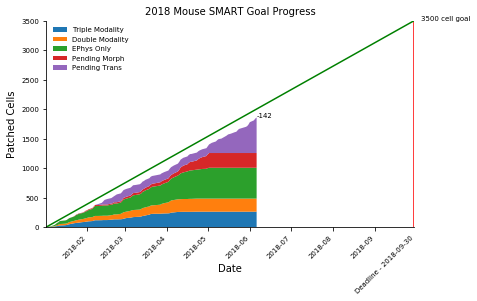

In [144]:
if __name__ == "__main__":
    data = read_data("../data/mouse_smart_data.csv")
    formatted_data = format_table(data)
    pivoted_data = pivot_table(formatted_data)
    plot = make_plot(pivoted_data)